### Stock returns rate and risk

Fonte: https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

In [5]:
dfcomp = df.pivot(index='date', columns='ticker', values='close')[['OIBR4', 'POMO4', 'ABEV3', 'ETER3', 'SAPR3']].dropna()
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr

ticker,OIBR4,POMO4,ABEV3,ETER3,SAPR3
ticker,,,,,
OIBR4,1.000000,0.229199,0.033697,0.000232,0.028931
POMO4,0.229199,1.000000,0.016283,-0.014610,0.050133
ABEV3,0.033697,0.016283,1.000000,-0.001694,0.001299
ETER3,0.000232,-0.014610,-0.001694,1.000000,0.000005
SAPR3,0.028931,0.050133,0.001299,0.000005,1.000000


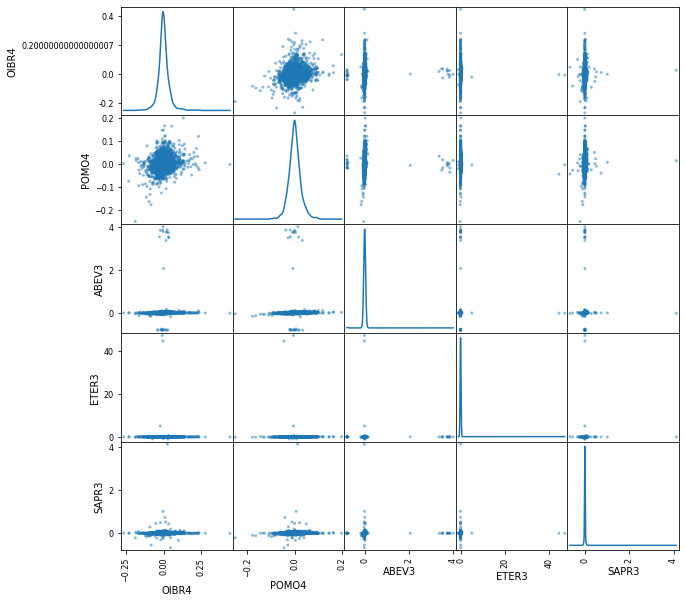

In [6]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

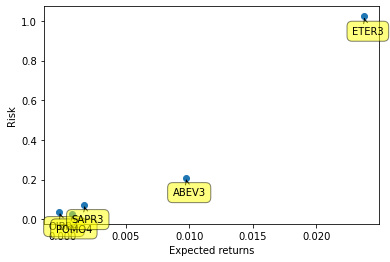

In [7]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()): 
    plt.annotate( 
        label, 
        xy = (x, y), 
        xytext = (20, -20), 
        textcoords = 'offset points', ha = 'right', va = 'bottom', 
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5), 
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
    )

### Predict stocks price

In [8]:
dfreg = df.loc[:, ['adj_close','volume']] 
dfreg['hl_pct'] = (df['high'] - df['low']) / df['close'] * 100.0 
dfreg['pct_change'] = (df['close'] - df['open']) / df['open'] * 100.0
dfreg

,adj_close,volume,hl_pct,pct_change
0,0.417716,16000.0,9.090909,3.773585
1,0.387336,5000.0,1.960784,-1.923077
2,0.311388,0.0,26.829268,-21.153846
3,0.341767,0.0,26.666667,-21.052632
4,0.364552,20000.0,6.250000,-2.040816
...,...,...,...,...
1145834,200.429993,21865.0,1.357083,0.551844
1145835,200.750000,5275.0,0.986299,0.299778
1145836,203.759995,39779.0,1.668627,1.373132
1145837,207.639999,9210.0,2.624734,1.679640


,adj_close,volume,hl_pct,pct_change,label
0,0.417716,16000.0,9.090909,3.773585,104.519997
1,0.387336,5000.0,1.960784,-1.923077,104.500000
2,0.311388,0.0,26.829268,-21.153846,104.730003
3,0.341767,0.0,26.666667,-21.052632,105.000000
4,0.364552,20000.0,6.250000,-2.040816,104.900002
...,...,...,...,...,...
1145834,200.429993,21865.0,1.357083,0.551844,-99999.000000
1145835,200.750000,5275.0,0.986299,0.299778,-99999.000000
1145836,203.759995,39779.0,1.668627,1.373132,-99999.000000
1145837,207.639999,9210.0,2.624734,1.679640,-99999.000000


In [18]:
# Drop missing value
dfreg = dfreg[dfreg != float('inf')]
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose 
forecast_col = 'adj_close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression 
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation 
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import Ridge 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline

# Linear regression 
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X, y)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)

confidencereg = clfreg.score(X, y)
confidencepoly2 = clfpoly2.score(X, y)
confidencepoly3 = clfpoly3.score(X, y)
confidenceknn = clfknn.score(X, y)

In [19]:
last_date = dfreg.iloc[-1].name 
last_unix = last_date 
next_unix = last_unix + datetime.timedelta(days=1) 
for i in tqdm(forecast_set):
    next_date = next_unix 
    next_unix += datetime.timedelta(days=1) 
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i] 
dfreg['adj_close'].tail(500).plot() 
dfreg['Forecast'].tail(500).plot() 
plt.legend(loc=4) 
plt.xlabel('date') 
plt.ylabel('price') 
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'datetime.timedelta'

### Implementação do perceptron

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import os
import datetime
from sklearn import tree
import math
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
class Model:
    def __init__(self, weights=None, bias=None):
        self.weights = weights
        self.bias = bias
    def predict(self, tst):
        u = get_u(self.weights, tst, self.bias)
        return activation_function(u) 

def get_u(w, x, bias, m_factor=1): # b = bias, w = weight, x = value
    return (w * x).sum() + m_factor * bias

def update_weights(weight, expected, predicted, x, a=0.4): # a = N
    return weight + a * x * (expected - predicted)

def update_bias(bias, expected, predicted, a=0.4):
    return bias + a * (expected - predicted)

def activation_function(u, threshold=0):
    return 1 if u >= threshold else -1

def get_error(expected, predicted, k, e=0):
    return e + (abs(expected - predicted) / k)

def buy_candles(df):
    return np.where((df['close'] < df['close'].shift(-5)) & (df['close'].shift(-5) >= (df['close'] + 2 * (df['close'] - df['open']))), 1, 0)


In [3]:
def crossing_ema_short_term(df):
    return np.where((df['close_ema8'] <= df['close_ema20']) & (df['close_ema8'].shift(-1) > df['close_ema20'].shift(-1)), 1, 0)
    
def crossing_ema_long_term(df):
    return np.where((df['close_ema8'] <= df['close_ema72']) & (df['close_ema8'].shift(-1) > df['close_ema72'].shift(-1)), 1, 0)

def candle_crossing_ema(df, period):
    return np.where(((df['close'] > df[f'close_ema{period}']) & (df['close'].shift(1) <= df[f'close_ema{period}'].shift(1))), 1, 0)

In [4]:
# weights = np.array([0.4, -0.6, 0.6])
# train = np.array([[0, 0, 1], [1, 1, 0]])
# vp = [-1, 1]
# bias = 0.5
# a = 0.4
# threshold = 0
# n_try = 100
# fit = False

# for _ in range(n_try):
#     for i, x in enumerate(train):
#         u = get_u(weights, x, bias)
#         predicted = activation_function(u)
#         if predicted != vp[i]:
#             fit = True
#             weights = update_weights(weights, vp[i], predicted, x, a=0.4)
#             bias = update_bias(bias, vp[i], predicted, a=0.4)
#             # print(weights, bias, sep = '\n')
#     if not fit: break
#     fit = False
# print(f'Modelo: w = {weights.round(2).tolist()} | bias = {bias}')

In [5]:
df = pd.read_csv('C:/Users/genic/Documents/GitHub/market_trading_analysis/hist_market_trading_yfinance.csv')
# df = df[df['ticker'] == 'ABEV3']
df.head()

,date,ticker,open,high,low,close,adj_close,volume,close_ema8,close_ema20,volume_ema20,close_ema72,ind_volume,macd,macd_signal,buy,sell
0,2020-02-07,A1AP34,143.119995,143.119995,143.119995,143.119995,143.119995,42900.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
1,2020-02-10,A1AP34,142.270004,142.270004,142.270004,142.270004,142.270004,3600.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2,2020-02-11,A1AP34,142.270004,142.270004,142.270004,142.270004,142.270004,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
3,2020-02-12,A1AP34,142.270004,142.270004,142.270004,142.270004,142.270004,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
4,2020-02-13,A1AP34,147.369995,147.369995,147.369995,147.369995,147.369995,1600.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0


In [6]:
def prepare_df_to_ml(df, frac_test=0.30, best_ret=False):
    dataset = pd.DataFrame()
    if best_ret: # Tenta predizer se o candle atual dará bons retornos com base na variável `buy`
        dataset['candle_crossing_ema8'] = candle_crossing_ema(df, period=8)
        dataset['candle_crossing_ema20'] = candle_crossing_ema(df, period=20)
        dataset['candle_crossing_ema72'] = candle_crossing_ema(df, period=72)
        dataset['crossing_ema_short_term'] = crossing_ema_short_term(df)
        dataset['crossing_ema_long_term'] = crossing_ema_long_term(df)
        dataset['today_candle'] = np.where(df['close'] > df['open'], 1, 0)
        dataset['trend_today'] = np.where(df['close'] > df['close'].shift(1), 1, 0)
        dataset['ind_volume'] = np.where(df['ind_volume'] >= 0, 1, 0)
        dataset['macd_signal'] = np.where(df['macd'] >= df['macd_signal'], 1, 0)
        dataset['trend_tomorrow'] = np.where(df['close'] < df['close'].shift(-1), 1, 0)
        dataset['ema8_position'] = np.where(df['close'] >= df['close_ema8'], 1, 0)
        dataset['ema20_position'] = np.where(df['close'] >= df['close_ema20'], 1, 0)
        dataset['ema72_position'] = np.where(df['close'] >= df['close_ema72'], 1, 0)
        dataset['y'] = df['buy'].values
        dataset = dataset.drop_duplicates()
        test_ids = np.random.randint(0, dataset.shape[0], int(frac_test*dataset.shape[0]))
        test_ids = dataset.iloc[test_ids].index
        train = dataset[~dataset.index.isin(test_ids)]
        test = dataset[dataset.index.isin(test_ids)]
    else: # Tenta predizer como será o candle de amanhã
        tmp = df.iloc[:-1, :]
        dataset = pd.DataFrame({
            'candle_crossing_ema8': candle_crossing_ema(tmp, period=8), 
            'candle_crossing_ema20': candle_crossing_ema(tmp, period=20), 
            'candle_crossing_ema72': candle_crossing_ema(tmp, period=72), 
            'crossing_ema_short_term': crossing_ema_short_term(tmp), 
            'crossing_ema_long_term': crossing_ema_long_term(tmp), 
            'today_candle': np.where(tmp['close'] > tmp['open'], 1, 0), 
            'trend_today': np.where(tmp['close'] > tmp['close'].shift(1), 1, 0), 
            'volume_gte_ema20': np.where(tmp['ind_volume'] >= 0, 1, 0), 
            'macd_signal': np.where(tmp['macd'] >= tmp['macd_signal'], 1, 0), 
            'ema8_position': np.where(tmp['close'] >= tmp['close_ema8'], 1, 0), 
            'ema20_position': np.where(tmp['close'] >= tmp['close_ema20'], 1, 0), 
            'ema72_position': np.where(tmp['close'] >= tmp['close_ema72'], 1, 0), 
            'y': np.where(df['close'] < df['close'].shift(-1), 1, 0)[:-1], # trend_tomorrow
        })
        dataset = dataset.drop_duplicates()
        test_ids = np.random.randint(0, dataset.shape[0], int(frac_test*dataset.shape[0]))
        test_ids = dataset.iloc[test_ids].index
        train = dataset[~dataset.index.isin(test_ids)]
        test = dataset[dataset.index.isin(test_ids)]
    return train, test

def check_model(m, test):
    X = test.iloc[:, :-1]
    Y = test.iloc[:, -1]
    qtd_errors = 0
    for i in range(X.shape[0]):
        y_predict = m.predict(X.iloc[i])
        if y_predict != Y.iloc[i]:
            qtd_errors += 1
    acc = 100 - (qtd_errors / test.shape[0] * 100)
    print(f'Acurácia: {acc}%')
    return acc

Teste para colocar o perceptron como função

In [ ]:
def perceptron(df):
    bias = 0.5
    a = 0.4
    threshold = 0
    n_try = 200 # 200
    fit = False

    train, test = prepare_df_to_ml(tmp)
    if test.shape[0] == 0: continue
    label = train.iloc[:, -1]
    train = train.iloc[:, :-1] # remove a coluna da predição
    weights = np.random.random(train.shape[1])

    errors = np.array([])
    best_model = {'e': float('inf'), 'model': None}
    for _ in tqdm(range(n_try)):
        e = 0
        for i in range(train.shape[0] - 1):
            x = train.iloc[i].to_numpy()
            expected = label.iloc[i]
            u = get_u(weights, x, bias)
            predicted = activation_function(u)
            if predicted != expected:
                fit = True
                weights = update_weights(weights, expected, predicted, x, a=0.4)
                bias = update_bias(bias, expected, predicted, a=0.4)
                e = get_error(expected, predicted, i + 1, e=e)
        if best_model['e'] > e:
            best_model['e'] = e
            best_model['model'] = Model(weights, bias)
        errors = np.append(errors, e)
        if not fit: break
        fit = False
    m = Model(weights, bias)
    # print(f'Best model: w = {best_model["model"].weights.round(2).tolist()} | bias = {best_model["model"].bias}')
    acc = check_model(m, test)
    # predictions = pd.DataFrame({'ticker': [ticker], 'model': [re.sub('[ \n]+', ' ', str(a))], 'acc': [acc]})
    return {'model': [m], 'acc': [acc]} # predictions

In [88]:
best_ticker_acc = {'ticker': None, 'acc': None}
predictions = pd.DataFrame()
for i, ticker in enumerate(df['ticker'].unique()):
    tmp = df[df['ticker'] == ticker]
    print(f'[{i+1}/{len(df["ticker"].unique())}] ticker: {ticker}', *tmp.shape)
    # # # perceptron(tmp) # # # 
    bias = 0.5
    a = 0.4
    threshold = 0
    n_try = 200 # 200
    fit = False

    train, test = prepare_df_to_ml(tmp)
    if test.shape[0] == 0: continue
    label = train.iloc[:, -1]
    train = train.iloc[:, :-1] # remove a coluna da predição
    weights = np.random.random(train.shape[1])

    # train = dataset.iloc[:-100, :-1]
    # label = dataset.iloc[:-100, -1]
    # test = dataset.iloc[-100:, :-1]#.to_frame().T

    errors = np.array([])
    best_model = {'e': float('inf'), 'model': None}

    for _ in tqdm(range(n_try)):
        e = 0
        for i in range(train.shape[0] - 1):
            x = train.iloc[i].to_numpy()
            expected = label.iloc[i]
            u = get_u(weights, x, bias)
            predicted = activation_function(u)
            if predicted != expected:
                fit = True
                weights = update_weights(weights, expected, predicted, x, a=0.4)
                bias = update_bias(bias, expected, predicted, a=0.4)
                e = get_error(expected, predicted, i + 1, e=e)
        if best_model['e'] > e:
            best_model['e'] = e
            best_model['model'] = Model(weights, bias)
        errors = np.append(errors, e)
        if not fit: break
        fit = False
    m = Model(weights, bias)
    print(f'Best model: w = {best_model["model"].weights.round(2).tolist()} | bias = {best_model["model"].bias}')
    acc = check_model(m, test)
    predictions = predictions.append(pd.DataFrame({'ticker': [ticker], 'model': [re.sub('[ \n]+', ' ', str(m.__dict__))], 'acc': [acc]}), ignore_index=True)
    if not best_ticker_acc['acc'] or acc > best_ticker_acc['acc']:
        best_ticker_acc['ticker'] = ticker
        best_ticker_acc['acc'] = acc
    print(f'Melhor acurácia até o momento: `{best_ticker_acc["ticker"]}` -> {round(best_ticker_acc["acc"], 2)}%')
    # plotar erros


  1%|▊                                                                                 | 2/200 [00:00<00:11, 17.54it/s]

[1/417] ticker: A1AP34 225 17



100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.88it/s]


Best model: w = [0.72, 0.12, 0.5, 1.33, 0.58, -0.31, 0.09, 0.03, -0.35, -1.11, 1.41, 0.2] | bias = 0.5000000000000007
Acurácia: 16.666666666666657%
Melhor acurácia até o momento: `A1AP34` -> 16.67%



  2%|█▋                                                                                | 4/200 [00:00<00:05, 34.79it/s]

[2/417] ticker: A1MD34 248 17



 31%|█████████████████████████                                                        | 62/200 [00:02<00:05, 24.68it/s]


KeyboardInterrupt: 

In [113]:
predictions.to_csv('C:/Users/genic/Documents/GitHub/market_trading_analysis/predictions.csv', header=True)

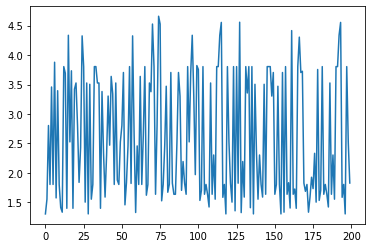

In [166]:
plt.plot(errors)

In [99]:
# [df['date'].shift(-5), df['low'], df['close'].shift(-5)]
# Mudar para pegar o proximo candle que tem o valor de fechamento igual ao dobro do candle atual (e não apenas se for o quinto dia)
def buy_candles(df):
    return np.where((df['close'] < df['close'].shift(-5)) & (df['close'].shift(-5) >= (df['close'] + 2 * (df['close'] - df['low']))), df['date'].shift(-5), 0)

def buy_candles_v2(df, qtd_days=8, gain_ratio=2):
    tmp = df.sort_values(by=['date']).copy()
    ids = {'buy': [], 'sell': []}
    for i in tqdm(tmp.index):
        if len(ids['sell']) > 0 and i <= ids['sell'][-1]:
            continue
        b = tmp.loc[i]
        s = (None, -1)
        for j in range(min(i+1, tmp.index[-1]), min(i + qtd_days, tmp.index[-1])):
            if ((tmp.loc[j]['close'] >= (b['close'] + gain_ratio * (b['close'] - b['low']))) and (tmp.loc[j]['close'] > s[1])):
                s = (j, tmp.loc[j]['close'])
        if s[0]:
            ids['buy'].append(i)
            ids['sell'].append(s[0])
    return ids

In [3]:
def get_trades_recom(df, qtd_days=8, gain_ratio=2, min_pct_gain=5): # min_pct_gain=5
    tmp = df.sort_values(by=['date']).copy()
    ids = {'buy': [], 'sell': []}
    for i in tqdm(range(tmp.shape[0] - 1)):
        if len(ids['sell']) > 0 and i <= ids['sell'][-1]:
            continue
        b = tmp.iloc[i]
        s = (None, -1)
        for j in range(i + 1, i + qtd_days):
            if j == tmp.shape[0]:
                break
            target = b['close'] + gain_ratio * (b['close'] - b['low'])
            gain = tmp.iloc[j]['close'] - b['close']
            if ((tmp.iloc[j]['close'] >= target) and (tmp.iloc[j]['close'] > s[1])):
                if not min_pct_gain:
                    s = (j, tmp.iloc[j]['close'])
                elif gain >= min_pct_gain/100 * b['close']:
                    s = (j, tmp.iloc[j]['close'])
        if s[0]:
            ids['buy'].append(i)
            ids['sell'].append(s[0])
    trades_buy = tmp.iloc[ids['buy']][['date', 'close', 'low']].reset_index().rename(columns={'date': 'buy_date', 'index': 'original_index', 'low': 'loss'}).reset_index()
    trades_sell = tmp.iloc[ids['sell']][['date', 'close']].reset_index(drop=True).rename(columns={'date': 'sell_date', 'close': 'gain'}).reset_index()
    return trades_buy.merge(trades_sell, on=['index'], how='inner').drop('index', axis=1).rename(columns={'original_index': 'index'})

In [4]:
df = pd.read_csv('C:/Users/genic/Documents/GitHub/market_trading_analysis/hist_market_trading_yfinance.csv')
df = df[df['ticker']=='OIBR4']

In [5]:
t_s = datetime.datetime.now()
buy_candles = get_trades_recom(df)
buy_dates = buy_candles['buy_date']
df_buy = df[df['date'].isin(buy_dates)]
df_sell = df[~df['date'].isin(buy_dates)]
df = df_buy.assign(buy=1).append(df_sell.assign(buy=0))
print(datetime.datetime.now() - t_s)

100%|██████████████████████████████████████████████████████████████████████████████| 4646/4646 [01:11<00:00, 65.42it/s]


0:01:11.134667


In [34]:
dataset = pd.DataFrame()
dataset['candle_crossing_ema8'] = candle_crossing_ema(df, period=8)
dataset['candle_crossing_ema20'] = candle_crossing_ema(df, period=20)
dataset['candle_crossing_ema72'] = candle_crossing_ema(df, period=72)
dataset['crossing_ema_short_term'] = crossing_ema_short_term(df)
dataset['crossing_ema_long_term'] = crossing_ema_long_term(df)
dataset['today_candle'] = np.where(df['close'] > df['open'], 1, 0)
dataset['trend_today'] = np.where(df['close'] > df['close'].shift(1), 1, 0)
dataset['ind_volume'] = np.where(df['ind_volume'] >= 0, 1, 0)
dataset['macd_signal'] = np.where(df['macd'] >= df['macd_signal'], 1, 0)
dataset['trend_tomorrow'] = np.where(df['close'] < df['close'].shift(-1), 1, 0)
dataset['ema8_position'] = np.where(df['close'] >= df['close_ema8'], 1, 0)
dataset['ema20_position'] = np.where(df['close'] >= df['close_ema20'], 1, 0)
dataset['ema72_position'] = np.where(df['close'] >= df['close_ema72'], 1, 0)
dataset['y'] = df['buy'].values
dataset = dataset.drop_duplicates()
test_ids = np.random.randint(1, dataset.shape[0], int(30/100*dataset.shape[0]))
test_ids = dataset.iloc[test_ids].index
# dataset.index = df.index
# test = df_buy.iloc[-1]
train = dataset[~dataset.index.isin(test_ids)]
test = dataset[dataset.index.isin(test_ids)].drop('y', axis=1)
X = train.drop('y', axis=1)
Y = train[['y']]

In [109]:
def agg_weights(labels, weights):
    tmp = pd.DataFrame({'labels': labels, 'weights': weights})
    scores = tmp.groupby('labels').sum().reset_index()
    # id of the max score
    max_score_indice = scores['weights'].idxmax()
    # label of the max score
    predict_label = scores.loc[max_score_indice]['labels']
    return predict_label

# Calculate the Euclidian Distance
def euclidian_distance(x, y):
    return math.sqrt((x - y).pow(2).sum())

def wknn(data, rotulo, k, test, task='r'):
    # Calculate the distance of test and all elements of data train
    # for i in range(data.shape[0]):
        # dists.append(euclidian_distance(data.iloc[i], test.iloc[0]))
    dists = data.apply(euclidian_distance, args=(test.iloc[0],), axis=1)
    # relation between distances and weights
    proximities = 1/dists
    
    k_nearest_indices = [x[0] for x in sorted(zip(dists.index, dists), key=lambda x: x[1])[:k]]
    candidates = rotulo.loc[k_nearest_indices]
    weights = proximities.loc[k_nearest_indices]
    
    if task == 'c':
        return agg_weights(candidates, weights)
    return candidates.mean()
# EXAMPLE: testing wknn (example for classification)
d = train.copy() # dataset
r = label.copy() # labels
n = test.iloc[0, :-10] # new example

wknn(data=d, rotulo=r, k = 5, test=n, task="c")

0.0

In [111]:
best_ticker_acc = {'ticker': None, 'acc': None}
predictions = pd.DataFrame()
for i, ticker in tqdm(enumerate(df['ticker'].unique())):
    tmp = df[df['ticker'] == ticker]
    print(f'[{i+1}/{len(df["ticker"].unique())}] ticker: {ticker}', *tmp.shape)

    train, test = prepare_df_to_ml(tmp)
    if test.shape[0] == 0: continue
    label = train.iloc[:, -1]
    train = train.iloc[:, :-1] # remove a coluna da predição
    
    # EXAMPLE: testing wknn (example for classification)
    d = train.copy() # dataset
    r = label.copy() # labels
    # n = test.copy() # new example

    result = []
    for i in range(test.shape[0]):
        n = test.iloc[i, :-1]
        result.append(wknn(data=d, rotulo=r, k = 5, test=n, task="c"))
    # check_model
    qtd_errors = 0
    for i in range(len(result)):
        y_predict = result[i]
        if y_predict != test.iloc[i, -1]:
            qtd_errors += 1
    acc = 100 - (qtd_errors / test.shape[0] * 100)
    print(f'Acurácia: {acc}%')
    predictions = predictions.append(pd.DataFrame({'ticker': [ticker], 'acc': [acc]}))
    if not best_ticker_acc['acc'] or acc > best_ticker_acc['acc']:
        best_ticker_acc['ticker'] = ticker
        best_ticker_acc['acc'] = acc
    print(f'Melhor acurácia até o momento: `{best_ticker_acc["ticker"]}` -> {round(best_ticker_acc["acc"], 2)}%')


0it [00:00, ?it/s]

[1/417] ticker: A1AP34 225 17



1it [00:01,  1.27s/it]

Acurácia: 42.85714285714286%
Melhor acurácia até o momento: `A1AP34` -> 42.86%
[2/417] ticker: A1MD34 248 17



2it [00:03,  1.63s/it]

Acurácia: 48.14814814814815%
Melhor acurácia até o momento: `A1MD34` -> 48.15%
[3/417] ticker: AALR3 1042 17



3it [00:10,  3.24s/it]

Acurácia: 51.666666666666664%
Melhor acurácia até o momento: `AALR3` -> 51.67%
[4/417] ticker: AAPL34 2201 17



4it [00:25,  6.59s/it]

Acurácia: 41.463414634146346%
Melhor acurácia até o momento: `AALR3` -> 51.67%
[5/417] ticker: ABCB4 3290 17



5it [00:41,  9.62s/it]

Acurácia: 61.95652173913043%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[6/417] ticker: ABEV3 5283 17



6it [01:07, 14.40s/it]

Acurácia: 45.08196721311475%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[7/417] ticker: AERI3 35 17



7it [01:07, 10.17s/it]

Acurácia: 20.0%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[8/417] ticker: AFCR11 140 17



8it [01:08,  7.31s/it]

Acurácia: 53.333333333333336%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[9/417] ticker: AGRO3 3645 17



9it [01:26, 10.54s/it]

Acurácia: 54.16666666666667%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[10/417] ticker: ALPA4 3228 17



10it [01:41, 12.00s/it]

Acurácia: 45.45454545454546%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[11/417] ticker: ALPK3 156 17



11it [01:42,  8.68s/it]

Acurácia: 52.631578947368425%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[12/417] ticker: ALUP11 1914 17



12it [01:52,  8.93s/it]

Acurácia: 45.205479452054796%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[13/417] ticker: ALUP3 1059 17



13it [02:02,  9.34s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[14/417] ticker: ALUP4 1076 17



14it [02:12,  9.51s/it]

Acurácia: 46.42857142857143%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[15/417] ticker: ALZR11 743 17



15it [02:20,  9.17s/it]

Acurácia: 45.28301886792453%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[16/417] ticker: AMBP3 120 17



16it [02:22,  6.78s/it]

Acurácia: 42.85714285714286%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[17/417] ticker: AMZO34 2214 17



17it [02:34,  8.60s/it]

Acurácia: 47.14285714285714%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[18/417] ticker: ANIM3 1784 17



18it [02:47,  9.87s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[19/417] ticker: APER3 2525 17



19it [03:03, 11.78s/it]

Acurácia: 53.24675324675325%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[20/417] ticker: ARRI11 140 17



20it [03:05,  8.70s/it]

Acurácia: 52.38095238095239%
Melhor acurácia até o momento: `ABCB4` -> 61.96%
[21/417] ticker: ARZZ3 2463 17



21it [03:20, 10.64s/it]

Acurácia: 64.36781609195401%
Melhor acurácia até o momento: `ARZZ3` -> 64.37%
[22/417] ticker: ASML34 258 17



22it [03:21,  7.76s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `ARZZ3` -> 64.37%
[23/417] ticker: ATOM3 5153 17



23it [03:46, 12.92s/it]

Acurácia: 42.391304347826086%
Melhor acurácia até o momento: `ARZZ3` -> 64.37%
[24/417] ticker: ATSA11 812 17



24it [03:47,  9.28s/it]

Acurácia: 12.5%
Melhor acurácia até o momento: `ARZZ3` -> 64.37%
[25/417] ticker: AURA32 124 17



25it [03:48,  6.93s/it]

Acurácia: 66.66666666666667%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[26/417] ticker: AZEV3 2390 17



26it [03:55,  6.89s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[27/417] ticker: AZEV4 5246 17



27it [04:09,  8.86s/it]

Acurácia: 58.82352941176471%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[28/417] ticker: AZUL4 931 17



28it [04:18,  8.96s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[29/417] ticker: B3SA3 2399 17



29it [04:40, 12.91s/it]

Acurácia: 42.50000000000001%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[30/417] ticker: BABA34 269 17



30it [04:47, 11.02s/it]

Acurácia: 51.515151515151516%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[31/417] ticker: BBAS3 5285 17



31it [05:36, 22.57s/it]

Acurácia: 58.771929824561404%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[32/417] ticker: BBPO11 1596 17



32it [06:00, 22.84s/it]

Acurácia: 46.47887323943662%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[33/417] ticker: BBRC11 1596 17



33it [06:28, 24.59s/it]

Acurácia: 42.465753424657535%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[34/417] ticker: BBRK3 3268 17



34it [07:04, 27.88s/it]

Acurácia: 51.08695652173913%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[35/417] ticker: BBVJ11 1595 17



35it [07:18, 23.91s/it]

Acurácia: 51.35135135135135%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[36/417] ticker: BCFF11 813 17



36it [07:20, 17.12s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[37/417] ticker: BCIA11 806 17



37it [07:32, 15.73s/it]

Acurácia: 54.16666666666667%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[38/417] ticker: BCRI11 806 17



38it [07:45, 14.84s/it]

Acurácia: 51.92307692307692%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[39/417] ticker: BEEF3 3337 17



39it [08:10, 17.78s/it]

Acurácia: 52.27272727272727%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[40/417] ticker: BEES3 5285 17



40it [08:56, 26.27s/it]

Acurácia: 51.75438596491228%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[41/417] ticker: BERK34 1784 17



41it [09:19, 25.47s/it]

Acurácia: 51.42857142857143%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[42/417] ticker: BIDI3 364 17



42it [09:25, 19.50s/it]

Acurácia: 41.93548387096774%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[43/417] ticker: BIDI4 663 17



43it [09:35, 16.69s/it]

Acurácia: 59.183673469387756%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[44/417] ticker: BKBR3 755 17



44it [09:48, 15.62s/it]

Acurácia: 51.02040816326531%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[45/417] ticker: BMGB4 271 17



45it [09:52, 12.06s/it]

Acurácia: 59.375%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[46/417] ticker: BNFS11 1594 17



46it [10:12, 14.39s/it]

Acurácia: 62.857142857142854%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[47/417] ticker: BOAS3 60 17



47it [10:13, 10.35s/it]

Acurácia: 44.44444444444444%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[48/417] ticker: BOBR4 3228 17



48it [10:39, 15.13s/it]

Acurácia: 46.59090909090909%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[49/417] ticker: BOVA11 2122 17



49it [11:10, 19.94s/it]

Acurácia: 55.42168674698795%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[50/417] ticker: BOVB11 148 17



50it [11:12, 14.52s/it]

Acurácia: 52.17391304347826%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[51/417] ticker: BOVV11 1105 17



51it [11:28, 14.91s/it]

Acurácia: 51.42857142857143%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[52/417] ticker: BPAC11 961 17



52it [11:38, 13.43s/it]

Acurácia: 41.379310344827594%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[53/417] ticker: BPAC3 1119 17



53it [11:42, 10.84s/it]

Acurácia: 46.808510638297875%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[54/417] ticker: BPAN4 3255 17



54it [12:13, 16.77s/it]

Acurácia: 55.68181818181818%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[55/417] ticker: BPML11 140 17



55it [12:14, 12.12s/it]

Acurácia: 47.05882352941176%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[56/417] ticker: BRAP3 5285 17



56it [13:06, 24.02s/it]

Acurácia: 40.56603773584906%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[57/417] ticker: BRAP4 5125 17



57it [13:44, 28.02s/it]

Acurácia: 54.90196078431372%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[58/417] ticker: BRCO11 140 17



58it [13:44, 19.87s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[59/417] ticker: BRCR11 1596 17



59it [14:01, 18.80s/it]

Acurácia: 50.847457627118644%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[60/417] ticker: BRFS3 5285 17



60it [14:50, 27.94s/it]

Acurácia: 43.80952380952381%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[61/417] ticker: BRIV4 3228 17



61it [15:26, 30.46s/it]

Acurácia: 42.04545454545454%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[62/417] ticker: BRKM5 4588 17



62it [16:06, 33.37s/it]

Acurácia: 34.375%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[63/417] ticker: BRML3 3409 17



63it [16:28, 29.96s/it]

Acurácia: 41.05263157894738%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[64/417] ticker: BRPR3 2689 17



64it [16:48, 26.82s/it]

Acurácia: 45.238095238095234%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[65/417] ticker: BRSR6 3228 17



65it [17:06, 24.06s/it]

Acurácia: 43.20987654320988%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[66/417] ticker: BSEV3 1917 17



66it [17:19, 20.76s/it]

Acurácia: 57.57575757575758%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[67/417] ticker: BTCR11 497 17



67it [17:22, 15.59s/it]

Acurácia: 47.22222222222222%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[68/417] ticker: BTLG11 140 17



68it [17:23, 11.09s/it]
69it [17:23,  7.81s/it]

Acurácia: 66.66666666666667%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[69/417] ticker: BTLG12 1 17
[70/417] ticker: BTOW3 3922 17



70it [17:43, 11.42s/it]

Acurácia: 58.62068965517241%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[71/417] ticker: CAMB3 3003 17



71it [17:45,  8.72s/it]

Acurácia: 48.14814814814815%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[72/417] ticker: CAML3 812 17



72it [17:51,  7.89s/it]

Acurácia: 44.89795918367348%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[73/417] ticker: CARD3 3645 17



73it [18:17, 13.26s/it]

Acurácia: 43.47826086956522%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[74/417] ticker: CARE11 1596 17



74it [18:26, 12.15s/it]

Acurácia: 50.877192982456144%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[75/417] ticker: CBOP11 1595 17



75it [18:43, 13.49s/it]

Acurácia: 54.54545454545455%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[76/417] ticker: CCPR3 5285 17



76it [19:17, 19.71s/it]

Acurácia: 51.81818181818182%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[77/417] ticker: CCRO3 4741 17



77it [19:52, 24.23s/it]

Acurácia: 46.49122807017544%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[78/417] ticker: CEAB3 288 17



78it [19:55, 17.86s/it]

Acurácia: 58.62068965517241%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[79/417] ticker: CEBR6 2122 17



79it [20:01, 14.16s/it]

Acurácia: 56.52173913043478%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[80/417] ticker: CEOC11 1596 17



80it [20:12, 13.46s/it]

Acurácia: 45.714285714285715%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[81/417] ticker: CHVX34 2155 17



81it [20:22, 12.36s/it]

Acurácia: 55.0%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[82/417] ticker: CIEL3 2859 17



82it [20:44, 15.30s/it]

Acurácia: 54.8780487804878%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[83/417] ticker: CMIG3 5285 17



83it [21:27, 23.51s/it]

Acurácia: 45.53571428571429%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[84/417] ticker: CMIG4 5285 17



84it [22:05, 27.82s/it]

Acurácia: 49.54954954954955%
Melhor acurácia até o momento: `AURA32` -> 66.67%
[85/417] ticker: CNES11 1590 17



85it [22:09, 20.81s/it]

Acurácia: 87.5%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[86/417] ticker: CNTO3 427 17



86it [22:15, 16.16s/it]

Acurácia: 48.64864864864865%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[87/417] ticker: COCA34 2345 17



87it [22:28, 15.34s/it]

Acurácia: 65.51724137931035%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[88/417] ticker: COGN3 2187 17



88it [22:43, 15.29s/it]

Acurácia: 48.64864864864865%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[89/417] ticker: CPFE3 5285 17



89it [23:18, 21.17s/it]

Acurácia: 53.57142857142857%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[90/417] ticker: CPFF11 140 17



90it [23:20, 15.43s/it]

Acurácia: 25.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[91/417] ticker: CPLE3 5285 17



91it [24:00, 22.67s/it]

Acurácia: 43.103448275862064%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[92/417] ticker: CPLE6 5285 17



92it [24:39, 27.62s/it]


Acurácia: 43.518518518518526%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[93/417] ticker: CPTS11 1 17


93it [24:39, 19.39s/it]

[94/417] ticker: CRFB3 862 17



94it [24:48, 16.24s/it]

Acurácia: 46.42857142857143%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[95/417] ticker: CRPG5 5284 17



95it [25:21, 21.18s/it]

Acurácia: 48.0392156862745%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[96/417] ticker: CRPG6 5284 17



96it [25:44, 21.88s/it]

Acurácia: 50.56179775280899%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[97/417] ticker: CSAN3 3761 17



97it [26:11, 23.33s/it]

Acurácia: 53.191489361702125%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[98/417] ticker: CSMG3 3704 17



98it [26:39, 24.76s/it]

Acurácia: 45.833333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[99/417] ticker: CSNA3 5285 17



99it [27:09, 26.41s/it]

Acurácia: 51.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[100/417] ticker: CTKA4 5285 17



100it [27:44, 28.95s/it]

Acurácia: 53.271028037383175%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[101/417] ticker: CTNM4 5285 17



101it [28:20, 31.15s/it]

Acurácia: 42.241379310344826%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[102/417] ticker: CTSA3 5075 17



102it [28:52, 31.42s/it]

Acurácia: 57.407407407407405%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[103/417] ticker: CTSA4 5166 17



103it [29:16, 29.08s/it]

Acurácia: 62.5%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[104/417] ticker: CTXT11 1593 17



104it [29:35, 26.08s/it]

Acurácia: 58.108108108108105%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[105/417] ticker: CVBI11 140 17



105it [29:37, 18.79s/it]

Acurácia: 38.888888888888886%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[106/417] ticker: CVCB3 1756 17



106it [29:51, 17.32s/it]

Acurácia: 49.29577464788733%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[107/417] ticker: CVSH34 1171 17



107it [29:58, 14.28s/it]

Acurácia: 51.02040816326531%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[108/417] ticker: CYRE3 5285 17



108it [30:29, 19.36s/it]

Acurácia: 45.945945945945944%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[109/417] ticker: DIRR3 2759 17



109it [30:47, 18.96s/it]

Acurácia: 44.9438202247191%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[110/417] ticker: DISB34 2216 17



110it [31:01, 17.27s/it]

Acurácia: 46.37681159420289%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[111/417] ticker: DIVO11 2215 17



111it [31:18, 17.17s/it]

Acurácia: 53.75%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[112/417] ticker: DMAC11 511 17



112it [31:21, 12.98s/it]

Acurácia: 57.57575757575758%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[113/417] ticker: DMVF3 100 17



113it [31:21,  9.24s/it]

Acurácia: 54.54545454545455%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[114/417] ticker: DOHL4 5281 17



114it [31:38, 11.44s/it]

Acurácia: 58.82352941176471%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[115/417] ticker: DTEX3 3293 17



115it [31:57, 13.62s/it]

Acurácia: 45.238095238095234%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[116/417] ticker: EAIN34 370 17



116it [31:58,  9.89s/it]

Acurácia: 54.54545454545455%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[117/417] ticker: EALT4 5260 17



117it [32:24, 14.94s/it]

Acurácia: 53.46534653465346%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[118/417] ticker: ECOO11 2122 17



118it [32:39, 14.68s/it]

Acurácia: 52.17391304347826%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[119/417] ticker: ECOR3 2671 17



119it [32:55, 15.28s/it]

Acurácia: 50.60240963855422%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[120/417] ticker: EDGA11 1596 17



120it [33:01, 12.56s/it]

Acurácia: 62.264150943396224%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[121/417] ticker: EGIE3 4721 17



121it [33:43, 21.29s/it]

Acurácia: 50.43478260869565%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[122/417] ticker: ELET3 5285 17



122it [34:04, 21.13s/it]

Acurácia: 44.339622641509436%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[123/417] ticker: ELET6 3228 17



123it [34:18, 19.15s/it]

Acurácia: 50.57471264367816%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[124/417] ticker: EMBR3 5285 17



124it [34:43, 20.90s/it]

Acurácia: 43.85964912280702%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[125/417] ticker: ENAT3 2122 17



125it [35:00, 19.52s/it]

Acurácia: 40.74074074074075%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[126/417] ticker: ENGI3 5282 17



126it [35:18, 19.17s/it]

Acurácia: 56.25%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[127/417] ticker: ENGI4 3227 17



127it [35:36, 18.71s/it]

Acurácia: 52.68817204301075%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[128/417] ticker: ENJU3 38 17



128it [35:36, 13.17s/it]

Acurácia: 0.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[129/417] ticker: EQTL3 3164 17



129it [35:52, 14.02s/it]

Acurácia: 43.01075268817204%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[130/417] ticker: ESTR4 5284 17



130it [36:14, 16.30s/it]

Acurácia: 51.886792452830186%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[131/417] ticker: ETER3 5285 17



131it [36:39, 18.98s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[132/417] ticker: EUCA4 5285 17



132it [37:03, 20.56s/it]

Acurácia: 49.494949494949495%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[133/417] ticker: EURO11 2568 17



133it [37:20, 19.51s/it]

Acurácia: 50.526315789473685%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[134/417] ticker: EVEN3 3412 17



134it [37:44, 20.91s/it]

Acurácia: 42.708333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[135/417] ticker: EXXO34 2183 17



135it [37:55, 17.88s/it]

Acurácia: 55.88235294117647%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[136/417] ticker: EZTC3 3356 17



136it [38:09, 16.86s/it]
137it [38:10, 11.84s/it]

Acurácia: 61.627906976744185%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[137/417] ticker: FAED11 1 17
[138/417] ticker: FBOK34 1697 17



138it [38:18, 10.73s/it]

Acurácia: 57.971014492753625%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[139/417] ticker: FCFL11 1596 17



139it [38:30, 11.32s/it]

Acurácia: 52.56410256410257%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[140/417] ticker: FESA4 5285 17



140it [38:59, 16.60s/it]
141it [39:00, 11.66s/it]

Acurácia: 46.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[141/417] ticker: FEXC11 813 17
[142/417] ticker: FHER3 3405 17



142it [39:16, 13.20s/it]

Acurácia: 50.54945054945055%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[143/417] ticker: FIGS11 1596 17



143it [39:26, 12.04s/it]

Acurácia: 43.66197183098591%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[144/417] ticker: FIIB11 1595 17



144it [39:33, 10.59s/it]

Acurácia: 56.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[145/417] ticker: FIND11 2419 17



145it [39:46, 11.37s/it]

Acurácia: 60.526315789473685%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[146/417] ticker: FIVN11 1440 17



146it [39:51,  9.46s/it]

Acurácia: 56.86274509803921%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[147/417] ticker: FLMA11 1596 17



147it [40:02, 10.06s/it]
148it [40:03,  7.08s/it]

Acurácia: 46.25%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[148/417] ticker: FNAM11 1 17
[149/417] ticker: FNOR11 5285 17



149it [40:25, 11.58s/it]

Acurácia: 53.398058252427184%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[150/417] ticker: FSRF11 3227 17



150it [40:32, 10.27s/it]

Acurácia: 51.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[151/417] ticker: GEOO34 2305 17



151it [40:41,  9.99s/it]

Acurácia: 52.11267605633803%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[152/417] ticker: GFSA3 4341 17



152it [40:57, 11.58s/it]

Acurácia: 41.93548387096774%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[153/417] ticker: GGBR3 5285 17



153it [41:24, 16.47s/it]

Acurácia: 38.26086956521739%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[154/417] ticker: GGBR4 5199 17



154it [41:46, 18.05s/it]

Acurácia: 61.32075471698113%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[155/417] ticker: GILD34 1171 17



155it [41:51, 13.98s/it]

Acurácia: 51.06382978723404%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[156/417] ticker: GMAT3 56 17



156it [41:51,  9.88s/it]

Acurácia: 28.57142857142857%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[157/417] ticker: GOAU3 2122 17



157it [42:01, 10.06s/it]

Acurácia: 57.33333333333333%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[158/417] ticker: GOAU4 5199 17



158it [42:22, 13.35s/it]

Acurácia: 45.04504504504504%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[159/417] ticker: GOGL34 1163 17



159it [42:31, 11.87s/it]

Acurácia: 59.090909090909086%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[160/417] ticker: GOGL35 1163 17



160it [42:37, 10.05s/it]

Acurácia: 47.27272727272728%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[161/417] ticker: GOLL4 4117 17



161it [42:53, 11.89s/it]

Acurácia: 45.74468085106383%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[162/417] ticker: GOVE11 2275 17



162it [43:08, 12.72s/it]

Acurácia: 42.04545454545454%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[163/417] ticker: GPCP3 5226 17



163it [43:25, 14.03s/it]

Acurácia: 60.869565217391305%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[164/417] ticker: GPIV33 3621 17



164it [43:44, 15.65s/it]

Acurácia: 52.631578947368425%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[165/417] ticker: GRND3 4026 17



165it [44:02, 16.31s/it]

Acurácia: 51.04166666666667%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[166/417] ticker: GTWR11 382 17



166it [44:05, 12.49s/it]

Acurácia: 52.38095238095239%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[167/417] ticker: GUAR3 2122 17



167it [44:17, 12.23s/it]

Acurácia: 48.75000000000001%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[168/417] ticker: HABT11 353 17



168it [44:20,  9.33s/it]

Acurácia: 51.35135135135135%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[169/417] ticker: HAGA4 2122 17



169it [44:32, 10.36s/it]

Acurácia: 48.275862068965516%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[170/417] ticker: HAPV3 667 17



170it [44:36,  8.36s/it]

Acurácia: 55.81395348837209%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[171/417] ticker: HBOR3 3268 17



171it [44:49,  9.75s/it]

Acurácia: 48.80952380952381%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[172/417] ticker: HBSA3 67 17



172it [44:50,  6.96s/it]

Acurácia: 63.63636363636363%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[173/417] ticker: HFOF11 705 17



173it [44:54,  6.20s/it]

Acurácia: 47.82608695652174%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[174/417] ticker: HGBS11 2189 17



174it [45:06,  8.03s/it]

Acurácia: 47.43589743589743%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[175/417] ticker: HGCR11 1596 17



175it [45:19,  9.54s/it]

Acurácia: 37.9746835443038%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[176/417] ticker: HGFF11 337 17



176it [45:22,  7.56s/it]

Acurácia: 52.94117647058824%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[177/417] ticker: HGLG11 2443 17



177it [45:35,  9.12s/it]

Acurácia: 37.77777777777778%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[178/417] ticker: HGPO11 396 17



178it [45:38,  7.35s/it]

Acurácia: 40.54054054054054%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[179/417] ticker: HGRU11 603 17



179it [45:42,  6.39s/it]

Acurácia: 45.45454545454546%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[180/417] ticker: HLOG11 140 17



180it [45:43,  4.65s/it]

Acurácia: 28.57142857142857%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[181/417] ticker: HOSI11 140 17



181it [45:44,  3.51s/it]

Acurácia: 55.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[182/417] ticker: HPQB34 2151 17



182it [45:46,  3.15s/it]

Acurácia: 51.42857142857143%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[183/417] ticker: HRDF11 140 17



183it [45:47,  2.37s/it]
184it [45:47,  1.70s/it]

Acurácia: 60.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[184/417] ticker: HSAF11 1 17
[185/417] ticker: HSML11 344 17



185it [45:49,  1.76s/it]

Acurácia: 43.333333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[186/417] ticker: HTMX11 813 17



186it [45:51,  2.00s/it]

Acurácia: 37.5%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[187/417] ticker: HYPE3 3155 17



187it [46:06,  5.68s/it]

Acurácia: 47.25274725274725%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[188/417] ticker: IBFF11 140 17



188it [46:07,  4.28s/it]

Acurácia: 31.578947368421055%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[189/417] ticker: IDVL4 3333 17



189it [46:25,  8.49s/it]


Acurácia: 47.524752475247524%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[190/417] ticker: IFRA11 1 17


190it [46:25,  6.00s/it]

[191/417] ticker: IGBR3 5284 17



191it [46:49, 11.28s/it]

Acurácia: 41.80327868852459%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[192/417] ticker: IGTA3 3448 17



192it [47:05, 12.66s/it]

Acurácia: 45.833333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[193/417] ticker: IMAB11 407 17



193it [47:05,  9.12s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[194/417] ticker: INEP3 5257 17



194it [47:21, 11.11s/it]

Acurácia: 51.61290322580645%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[195/417] ticker: INEP4 5285 17



195it [47:43, 14.28s/it]

Acurácia: 48.24561403508771%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[196/417] ticker: IRBR3 855 17



196it [47:48, 11.45s/it]

Acurácia: 43.39622641509434%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[197/417] ticker: IRDM11 700 17



197it [47:52,  9.21s/it]

Acurácia: 33.33333333333334%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[198/417] ticker: ISUS11 2122 17



198it [48:03,  9.86s/it]

Acurácia: 45.12195121951219%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[199/417] ticker: ITSA3 5285 17



199it [48:27, 13.94s/it]

Acurácia: 43.333333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[200/417] ticker: ITSA4 5285 17



200it [48:51, 17.03s/it]

Acurácia: 50.81967213114754%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[201/417] ticker: ITUB3 5285 17



201it [49:12, 18.31s/it]

Acurácia: 47.32142857142857%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[202/417] ticker: ITUB4 5032 17



202it [49:34, 19.48s/it]

Acurácia: 45.689655172413794%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[203/417] ticker: IVVB11 1663 17



203it [49:38, 14.83s/it]

Acurácia: 40.90909090909091%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[204/417] ticker: JBDU3 2122 17



204it [49:45, 12.55s/it]

Acurácia: 51.515151515151516%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[205/417] ticker: JBDU4 5285 17



205it [49:59, 12.97s/it]

Acurácia: 55.55555555555556%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[206/417] ticker: JBSS3 3414 17



206it [50:13, 13.17s/it]

Acurácia: 57.608695652173914%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[207/417] ticker: JDCO34 290 17



207it [50:14,  9.56s/it]

Acurácia: 19.04761904761905%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[208/417] ticker: JPMC34 2155 17



208it [50:24,  9.73s/it]

Acurácia: 47.36842105263158%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[209/417] ticker: JPSA3 5163 17



209it [50:32,  9.02s/it]

Acurácia: 51.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[210/417] ticker: JRDM11 1596 17



210it [50:34,  6.99s/it]

Acurácia: 57.57575757575758%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[211/417] ticker: JSLG11 55 17



211it [50:34,  5.00s/it]

Acurácia: 44.44444444444444%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[212/417] ticker: JSRE11 1596 17



212it [50:44,  6.41s/it]
213it [50:44,  4.53s/it]

Acurácia: 52.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[213/417] ticker: KDIF11 1 17
[214/417] ticker: KEPL3 5053 17



214it [51:02,  8.59s/it]

Acurácia: 47.11538461538461%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[215/417] ticker: KFOF11 462 17



215it [51:06,  7.15s/it]

Acurácia: 31.111111111111114%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[216/417] ticker: KLBN11 1727 17



216it [51:16,  7.99s/it]

Acurácia: 40.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[217/417] ticker: KNCR11 1596 17



217it [51:25,  8.45s/it]

Acurácia: 43.05555555555556%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[218/417] ticker: KNIP11 806 17



218it [51:31,  7.51s/it]

Acurácia: 60.37735849056604%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[219/417] ticker: KNRI11 1596 17



219it [51:40,  7.96s/it]
220it [51:40,  5.62s/it]

Acurácia: 49.25373134328358%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[220/417] ticker: L1MN34 1 17
[221/417] ticker: LCAM3 2160 17



221it [51:50,  7.00s/it]

Acurácia: 46.15384615384615%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[222/417] ticker: LEVE3 2122 17



222it [52:01,  8.15s/it]

Acurácia: 45.45454545454546%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[223/417] ticker: LGCP11 140 17



223it [52:02,  6.01s/it]

Acurácia: 57.142857142857146%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[224/417] ticker: LIGT3 5285 17



224it [52:23, 10.41s/it]

Acurácia: 45.714285714285715%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[225/417] ticker: LINX3 1964 17



225it [52:33, 10.36s/it]

Acurácia: 55.128205128205124%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[226/417] ticker: LJQQ3 100 17



226it [52:33,  7.40s/it]

Acurácia: 63.63636363636363%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[227/417] ticker: LLIS3 3149 17



227it [52:47,  9.38s/it]

Acurácia: 46.15384615384615%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[228/417] ticker: LOGG3 503 17



228it [52:51,  7.65s/it]

Acurácia: 46.51162790697675%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[229/417] ticker: LOGN3 3357 17



229it [53:06,  9.72s/it]

Acurácia: 45.16129032258065%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[230/417] ticker: LPSB3 3481 17



230it [53:20, 11.05s/it]

Acurácia: 53.763440860215056%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[231/417] ticker: LREN3 2122 17



231it [53:31, 10.99s/it]

Acurácia: 51.25%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[232/417] ticker: LUGG11 140 17



232it [53:31,  7.92s/it]

Acurácia: 64.70588235294117%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[233/417] ticker: LWSA3 226 17



233it [53:32,  5.88s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[234/417] ticker: MALL11 511 17



234it [53:35,  5.01s/it]

Acurácia: 44.99999999999999%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[235/417] ticker: MCCI11 140 17



235it [53:37,  3.86s/it]

Acurácia: 58.33333333333333%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[236/417] ticker: MDIA3 3524 17



236it [53:50,  6.73s/it]

Acurácia: 47.72727272727273%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[237/417] ticker: MDNE3 221 17



237it [53:51,  5.13s/it]

Acurácia: 56.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[238/417] ticker: MEAL3 2437 17



238it [54:03,  7.14s/it]

Acurácia: 42.10526315789473%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[239/417] ticker: MELI34 389 17



239it [54:06,  5.88s/it]

Acurácia: 56.75675675675676%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[240/417] ticker: MELK3 65 17



240it [54:07,  4.24s/it]
241it [54:07,  3.01s/it]

Acurácia: 44.44444444444444%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[241/417] ticker: MFAI11 1 17
[242/417] ticker: MFII11 1596 17



242it [54:16,  4.74s/it]

Acurácia: 47.14285714285714%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[243/417] ticker: MGFF11 683 17



243it [54:20,  4.65s/it]

Acurácia: 63.265306122448976%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[244/417] ticker: MGLU3 2404 17



244it [54:30,  6.37s/it]

Acurácia: 52.631578947368425%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[245/417] ticker: MMXM11 1499 17



245it [54:38,  6.67s/it]

Acurácia: 39.682539682539684%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[246/417] ticker: MMXM3 3660 17



246it [54:51,  8.79s/it]

Acurácia: 43.37349397590361%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[247/417] ticker: MNDL3 4996 17



247it [55:07, 10.75s/it]

Acurácia: 59.375%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[248/417] ticker: MNPR3 5285 17



248it [55:23, 12.41s/it]

Acurácia: 59.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[249/417] ticker: MRFG3 3351 17



249it [55:38, 13.06s/it]

Acurácia: 46.808510638297875%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[250/417] ticker: MRVE3 3336 17



250it [55:51, 13.26s/it]

Acurácia: 48.837209302325576%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[251/417] ticker: MSFT34 2499 17



251it [56:00, 11.97s/it]

Acurácia: 46.57534246575342%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[252/417] ticker: MTRE3 223 17



252it [56:02,  8.79s/it]

Acurácia: 41.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[253/417] ticker: MWET4 5285 17



253it [56:20, 11.62s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[254/417] ticker: MXRF11 1596 17



254it [56:29, 10.81s/it]

Acurácia: 59.72222222222222%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[255/417] ticker: MYPK3 5285 17



255it [56:48, 13.30s/it]
256it [56:48,  9.36s/it]

Acurácia: 40.70796460176991%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[256/417] ticker: NCHB11 1 17
[257/417] ticker: NEOE3 377 17



257it [56:51,  7.46s/it]

Acurácia: 47.5%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[258/417] ticker: NSLU11 1596 17



258it [56:53,  5.85s/it]

Acurácia: 53.333333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[259/417] ticker: NVDC34 411 17



259it [56:55,  4.64s/it]

Acurácia: 62.06896551724138%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[260/417] ticker: ODPV3 3492 17



260it [57:13,  8.58s/it]

Acurácia: 46.93877551020408%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[261/417] ticker: OIBR3 4652 17



261it [57:37, 13.17s/it]

Acurácia: 49.13793103448276%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[262/417] ticker: OIBR4 4652 17



262it [57:55, 14.83s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[263/417] ticker: OMGE3 855 17



263it [58:00, 11.83s/it]

Acurácia: 51.92307692307692%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[264/417] ticker: ONEF11 1596 17



264it [58:11, 11.41s/it]

Acurácia: 52.7027027027027%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[265/417] ticker: ORCL34 2121 17



265it [58:17,  9.89s/it]

Acurácia: 61.016949152542374%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[266/417] ticker: OUJP11 806 17



266it [58:22,  8.37s/it]
267it [58:22,  5.90s/it]

Acurácia: 50.943396226415096%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[267/417] ticker: OULG11 1 17
[268/417] ticker: PARD3 969 17



268it [58:28,  5.88s/it]

Acurácia: 43.333333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[269/417] ticker: PATC11 438 17



269it [58:31,  5.03s/it]
270it [58:31,  3.56s/it]

Acurácia: 52.38095238095239%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[270/417] ticker: PATL11 1 17
[271/417] ticker: PDGR3 3456 17



271it [58:44,  6.27s/it]
272it [58:44,  4.43s/it]

Acurácia: 47.61904761904761%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[272/417] ticker: PDTC3 1 17
[273/417] ticker: PETR3 5285 17



273it [59:05,  9.58s/it]

Acurácia: 44.34782608695652%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[274/417] ticker: PETR4 5285 17



274it [59:26, 12.97s/it]

Acurácia: 44.03669724770643%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[275/417] ticker: PFRM3 3518 17



275it [59:42, 13.77s/it]

Acurácia: 47.19101123595506%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[276/417] ticker: PGMN3 82 17



276it [59:42,  9.82s/it]

Acurácia: 75.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[277/417] ticker: PIBB11 3640 17



277it [59:57, 11.18s/it]

Acurácia: 53.01204819277108%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[278/417] ticker: PLPL3 72 17



278it [59:57,  7.97s/it]

Acurácia: 40.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[279/417] ticker: PLRI11 1594 17



279it [1:00:07,  8.46s/it]

Acurácia: 62.6865671641791%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[280/417] ticker: PNVL3 5285 17



280it [1:00:26, 11.56s/it]

Acurácia: 46.875%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[281/417] ticker: PNVL4 5278 17



281it [1:00:35, 10.88s/it]

Acurácia: 73.13432835820896%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[282/417] ticker: POMO3 5283 17



282it [1:01:03, 16.08s/it]

Acurácia: 49.57983193277311%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[283/417] ticker: POMO4 5285 17



283it [1:01:35, 20.87s/it]

Acurácia: 57.93650793650794%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[284/417] ticker: PPLA11 2122 17



284it [1:01:46, 17.78s/it]

Acurácia: 55.072463768115945%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[285/417] ticker: PRIO3 2530 17



285it [1:02:00, 16.62s/it]

Acurácia: 51.851851851851855%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[286/417] ticker: PRNR3 219 17



286it [1:02:01, 12.17s/it]

Acurácia: 40.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[287/417] ticker: PSSA3 4010 17



287it [1:02:21, 14.32s/it]

Acurácia: 48.93617021276596%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[288/417] ticker: PTBL3 5285 17



288it [1:02:48, 18.32s/it]

Acurácia: 47.27272727272728%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[289/417] ticker: PYPL34 386 17



289it [1:02:51, 13.52s/it]

Acurácia: 48.38709677419355%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[290/417] ticker: QAGR11 264 17



290it [1:02:53, 10.09s/it]

Acurácia: 57.142857142857146%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[291/417] ticker: QUAL3 2363 17



291it [1:03:06, 10.98s/it]

Acurácia: 45.333333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[292/417] ticker: RADL3 5282 17



292it [1:03:25, 13.36s/it]

Acurácia: 48.958333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[293/417] ticker: RAIL3 1432 17



293it [1:03:35, 12.43s/it]

Acurácia: 40.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[294/417] ticker: RANI3 5284 17



294it [1:03:59, 15.96s/it]

Acurácia: 46.78899082568807%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[295/417] ticker: RANI4 3223 17



295it [1:04:08, 13.90s/it]

Acurácia: 56.92307692307692%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[296/417] ticker: RAPT3 5280 17



296it [1:04:34, 17.30s/it]

Acurácia: 51.851851851851855%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[297/417] ticker: RBCO11 131 17



297it [1:04:35, 12.44s/it]

Acurácia: 47.36842105263158%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[298/417] ticker: RBDS11 2500 17



298it [1:04:43, 11.14s/it]

Acurácia: 54.09836065573771%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[299/417] ticker: RBED11 418 17



299it [1:04:46,  8.79s/it]

Acurácia: 47.36842105263158%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[300/417] ticker: RBIV11 253 17



300it [1:04:48,  6.71s/it]

Acurácia: 57.69230769230769%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[301/417] ticker: RBRD11 1596 17



301it [1:04:59,  7.98s/it]

Acurácia: 41.42857142857142%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[302/417] ticker: RBRF11 806 17



302it [1:05:07,  7.85s/it]
303it [1:05:07,  5.55s/it]

Acurácia: 57.37704918032787%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[303/417] ticker: RBRL11 1 17
[304/417] ticker: RBRP11 590 17



304it [1:05:11,  5.06s/it]

Acurácia: 53.48837209302326%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[305/417] ticker: RBRR11 661 17



305it [1:05:16,  5.25s/it]

Acurácia: 49.01960784313726%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[306/417] ticker: RBRY11 404 17



306it [1:05:19,  4.56s/it]

Acurácia: 57.142857142857146%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[307/417] ticker: RBVA11 418 17



307it [1:05:21,  3.86s/it]

Acurácia: 51.61290322580645%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[308/417] ticker: RBVO11 1596 17



308it [1:05:32,  5.99s/it]

Acurácia: 51.38888888888889%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[309/417] ticker: RCFA11 314 17



309it [1:05:34,  4.54s/it]

Acurácia: 44.99999999999999%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[310/417] ticker: RCRB11 140 17



310it [1:05:34,  3.40s/it]

Acurácia: 43.75%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[311/417] ticker: RCSL3 5131 17



311it [1:05:47,  6.29s/it]

Acurácia: 44.30379746835443%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[312/417] ticker: RCSL4 5281 17



312it [1:06:10, 11.07s/it]

Acurácia: 45.54455445544554%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[313/417] ticker: RDNI3 3453 17



313it [1:06:30, 13.80s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[314/417] ticker: RDPD11 661 17



314it [1:06:35, 11.28s/it]

Acurácia: 53.191489361702125%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[315/417] ticker: RDSA34 259 17



315it [1:06:37,  8.35s/it]

Acurácia: 40.90909090909091%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[316/417] ticker: RECR11 1 17



316it [1:06:37,  5.90s/it]

[317/417] ticker: RECT11 419 17



317it [1:06:40,  5.21s/it]

Acurácia: 44.73684210526315%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[318/417] ticker: RFOF11 140 17



318it [1:06:42,  4.13s/it]

Acurácia: 52.17391304347826%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[319/417] ticker: RLOG3 1554 17



319it [1:06:51,  5.67s/it]

Acurácia: 36.50793650793651%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[320/417] ticker: RNGO11 1596 17



320it [1:07:03,  7.53s/it]

Acurácia: 54.16666666666667%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[321/417] ticker: ROMI3 5285 17



321it [1:07:27, 12.47s/it]

Acurácia: 51.851851851851855%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[322/417] ticker: RSID3 5285 17



322it [1:07:46, 14.35s/it]

Acurácia: 42.201834862385326%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[323/417] ticker: RVBI11 140 17



323it [1:07:48, 10.58s/it]

Acurácia: 59.090909090909086%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[324/417] ticker: SADI11 349 17



324it [1:07:49,  7.91s/it]

Acurácia: 40.74074074074075%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[325/417] ticker: SANB11 2788 17



325it [1:08:03,  9.64s/it]

Acurácia: 51.64835164835165%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[326/417] ticker: SANB3 5285 17



326it [1:08:21, 12.13s/it]

Acurácia: 41.12149532710281%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[327/417] ticker: SANB4 5285 17



327it [1:08:40, 14.07s/it]

Acurácia: 49.122807017543856%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[328/417] ticker: SAPR11 749 17



328it [1:08:43, 10.93s/it]

Acurácia: 55.319148936170215%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[329/417] ticker: SAPR4 3228 17



329it [1:09:00, 12.65s/it]

Acurácia: 50.51546391752577%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[330/417] ticker: SBSP3 5285 17



330it [1:09:15, 13.37s/it]

Acurácia: 40.5940594059406%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[331/417] ticker: SCPF11 1094 17



331it [1:09:19, 10.69s/it]

Acurácia: 44.44444444444444%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[332/417] ticker: SDIL11 1596 17



332it [1:09:26,  9.48s/it]

Acurácia: 62.31884057971014%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[333/417] ticker: SEER3 1783 17



333it [1:09:34,  9.11s/it]

Acurácia: 53.94736842105263%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[334/417] ticker: SGPS3 3332 17



334it [1:09:49, 10.70s/it]

Acurácia: 44.21052631578948%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[335/417] ticker: SHOW3 2388 17



335it [1:09:57, 10.02s/it]

Acurácia: 46.753246753246756%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[336/417] ticker: SHUL4 5285 17



336it [1:10:15, 12.46s/it]

Acurácia: 52.991452991452995%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[337/417] ticker: SIMH3 72 17



337it [1:10:16,  8.83s/it]

Acurácia: 45.45454545454546%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[338/417] ticker: SLBG34 2121 17



338it [1:10:18,  6.98s/it]

Acurácia: 57.5%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[339/417] ticker: SLCE3 3361 17



339it [1:10:28,  7.87s/it]

Acurácia: 49.411764705882355%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[340/417] ticker: SLED3 5285 17



340it [1:10:36,  7.84s/it]

Acurácia: 62.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[341/417] ticker: SLED4 2122 17



341it [1:10:43,  7.44s/it]

Acurácia: 49.27536231884058%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[342/417] ticker: SMAC11 210 17



342it [1:10:44,  5.59s/it]

Acurácia: 48.275862068965516%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[343/417] ticker: SMAL11 2998 17



343it [1:10:54,  6.97s/it]

Acurácia: 44.18604651162791%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[344/417] ticker: SMLS3 1911 17



344it [1:11:01,  7.03s/it]

Acurácia: 54.92957746478873%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[345/417] ticker: SMTO3 3445 17



345it [1:11:12,  8.27s/it]

Acurácia: 55.68181818181818%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[346/417] ticker: SNSY5 5285 17



346it [1:11:27, 10.05s/it]

Acurácia: 43.99999999999999%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[347/417] ticker: SOMA3 106 17



347it [1:11:27,  7.17s/it]

Acurácia: 41.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[348/417] ticker: SPTW11 1596 17



348it [1:11:34,  7.04s/it]

Acurácia: 41.666666666666664%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[349/417] ticker: SPXI11 1474 17



349it [1:11:40,  6.92s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[350/417] ticker: SQIA3 1946 17



350it [1:11:50,  7.65s/it]

Acurácia: 60.24096385542169%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[351/417] ticker: STBP3 2958 17



351it [1:11:54,  6.68s/it]

Acurácia: 46.42857142857143%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[352/417] ticker: SULA11 3283 17



352it [1:12:04,  7.77s/it]

Acurácia: 56.17977528089887%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[353/417] ticker: SULA4 936 17



353it [1:12:08,  6.52s/it]

Acurácia: 58.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[354/417] ticker: SUZB3 3388 17



354it [1:12:12,  5.64s/it]

Acurácia: 35.294117647058826%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[355/417] ticker: TAEE11 2122 17



355it [1:12:20,  6.57s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[356/417] ticker: TASA3 2122 17



356it [1:12:29,  7.10s/it]

Acurácia: 48.14814814814815%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[357/417] ticker: TCNO3 5279 17



357it [1:12:40,  8.24s/it]

Acurácia: 51.162790697674424%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[358/417] ticker: TCNO4 5284 17



358it [1:12:54, 10.23s/it]

Acurácia: 55.238095238095234%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[359/417] ticker: TCSA3 3452 17



359it [1:13:05, 10.37s/it]

Acurácia: 44.44444444444444%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[360/417] ticker: TECN3 2361 17



360it [1:13:13,  9.64s/it]

Acurácia: 45.56962025316456%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[361/417] ticker: TEKA4 5285 17



361it [1:13:27, 10.78s/it]

Acurácia: 40.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[362/417] ticker: TEND3 2122 17



362it [1:13:30,  8.66s/it]

Acurácia: 56.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[363/417] ticker: TEPP11 140 17



363it [1:13:31,  6.24s/it]

Acurácia: 41.17647058823529%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[364/417] ticker: TESA3 3499 17



364it [1:13:44,  8.19s/it]

Acurácia: 50.53763440860215%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[365/417] ticker: TEXA34 1333 17



365it [1:13:49,  7.36s/it]

Acurácia: 50.81967213114754%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[366/417] ticker: TGAR11 805 17



366it [1:13:50,  5.40s/it]

Acurácia: 60.869565217391305%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[367/417] ticker: TGMA3 3349 17



367it [1:14:02,  7.35s/it]

Acurácia: 46.7391304347826%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[368/417] ticker: THRA11 1596 17



368it [1:14:10,  7.74s/it]

Acurácia: 53.333333333333336%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[369/417] ticker: TIET11 1248 17



369it [1:14:17,  7.46s/it]

Acurácia: 52.17391304347826%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[370/417] ticker: TIET3 5285 17



370it [1:14:37, 11.16s/it]

Acurácia: 48.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[371/417] ticker: TIET4 2122 17



371it [1:14:46, 10.40s/it]

Acurácia: 46.98795180722891%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[372/417] ticker: TIMP3 3851 17



372it [1:15:00, 11.52s/it]
373it [1:15:00,  8.10s/it]

Acurácia: 46.53465346534653%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[373/417] ticker: TORD11 1 17
[374/417] ticker: TOTS3 3683 17



374it [1:15:14,  9.88s/it]

Acurácia: 56.19047619047619%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[375/417] ticker: TPIS3 3336 17



375it [1:15:26, 10.47s/it]

Acurácia: 43.87755102040817%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[376/417] ticker: TPRY34 369 17



376it [1:15:26,  7.48s/it]
377it [1:15:26,  5.29s/it]

Acurácia: 60.0%
Melhor acurácia até o momento: `CNES11` -> 87.5%
[377/417] ticker: TRNT11 812 17
Acurácia: 100.0%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[378/417] ticker: TRPL3 2122 17



378it [1:15:34,  6.08s/it]

Acurácia: 53.84615384615385%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[379/417] ticker: TRPL4 5285 17



379it [1:15:49,  8.66s/it]

Acurácia: 48.0392156862745%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[380/417] ticker: TRXF11 140 17



380it [1:15:50,  6.24s/it]

Acurácia: 58.82352941176471%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[381/417] ticker: TSLA34 986 17



381it [1:15:52,  5.21s/it]

Acurácia: 48.88888888888889%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[382/417] ticker: TUPY3 5285 17



382it [1:16:07,  8.09s/it]

Acurácia: 48.14814814814815%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[383/417] ticker: UCAS3 2156 17



383it [1:16:15,  8.09s/it]

Acurácia: 44.73684210526315%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[384/417] ticker: UGPA3 4518 17



384it [1:16:25,  8.46s/it]

Acurácia: 55.29411764705882%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[385/417] ticker: ULEV34 294 17



385it [1:16:26,  6.20s/it]
386it [1:16:26,  4.38s/it]

Acurácia: 62.5%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[386/417] ticker: URPR11 1 17
[387/417] ticker: USIM3 5284 17



387it [1:16:46,  9.01s/it]

Acurácia: 44.628099173553714%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[388/417] ticker: VALE3 5285 17



388it [1:17:07, 12.62s/it]

Acurácia: 49.557522123893804%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[389/417] ticker: VIFI11 140 17



389it [1:17:07,  9.02s/it]

Acurácia: 38.888888888888886%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[390/417] ticker: VILG11 448 17



390it [1:17:10,  7.06s/it]

Acurácia: 51.35135135135135%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[391/417] ticker: VINO11 140 17



391it [1:17:10,  5.17s/it]

Acurácia: 38.888888888888886%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[392/417] ticker: VISC11 788 17



392it [1:17:14,  4.56s/it]

Acurácia: 47.82608695652174%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[393/417] ticker: VIVA3 304 17



393it [1:17:16,  3.85s/it]
394it [1:17:16,  2.73s/it]

Acurácia: 48.484848484848484%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[394/417] ticker: VIVR1 1 17
[395/417] ticker: VIVT3 5285 17



395it [1:17:38,  8.44s/it]

Acurácia: 48.69565217391304%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[396/417] ticker: VLID3 3648 17



396it [1:17:51,  9.87s/it]

Acurácia: 44.827586206896555%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[397/417] ticker: VLOL11 1596 17



397it [1:18:02, 10.17s/it]

Acurácia: 50.617283950617285%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[398/417] ticker: VOTS11 609 17



398it [1:18:04,  7.73s/it]

Acurácia: 69.69696969696969%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[399/417] ticker: VRTA11 1596 17



399it [1:18:13,  8.05s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[400/417] ticker: VTLT11 666 17



400it [1:18:16,  6.64s/it]

Acurácia: 53.48837209302326%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[401/417] ticker: VULC3 5246 17



401it [1:18:29,  8.60s/it]

Acurácia: 51.111111111111114%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[402/417] ticker: VVAR3 5285 17



402it [1:18:47, 11.37s/it]

Acurácia: 53.46534653465346%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[403/417] ticker: VVPR11 140 17



403it [1:18:48,  8.26s/it]

Acurácia: 60.0%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[404/417] ticker: WEGE3 5285 17



404it [1:19:10, 12.54s/it]

Acurácia: 57.69230769230769%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[405/417] ticker: WHRL3 5285 17



405it [1:19:31, 14.86s/it]

Acurácia: 49.532710280373834%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[406/417] ticker: WHRL4 2122 17



406it [1:19:46, 15.05s/it]

Acurácia: 52.17391304347826%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[407/417] ticker: WIZS3 1390 17



407it [1:19:53, 12.58s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[408/417] ticker: WLMM3 870 17



408it [1:19:55,  9.41s/it]

Acurácia: 64.51612903225806%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[409/417] ticker: WPLZ11 1595 17



409it [1:20:00,  7.97s/it]
410it [1:20:00,  5.61s/it]

Acurácia: 50.0%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[410/417] ticker: XPIE11 1 17
[411/417] ticker: XPIN11 253 17



411it [1:20:01,  4.25s/it]

Acurácia: 54.54545454545455%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[412/417] ticker: XPLG11 638 17



412it [1:20:04,  3.85s/it]

Acurácia: 54.54545454545455%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[413/417] ticker: XPML11 747 17



413it [1:20:08,  4.00s/it]

Acurácia: 58.33333333333333%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[414/417] ticker: XPPR11 140 17



414it [1:20:09,  2.98s/it]

Acurácia: 46.666666666666664%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[415/417] ticker: XPSF11 140 17



415it [1:20:10,  2.33s/it]

Acurácia: 47.05882352941176%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[416/417] ticker: XTED11 1596 17



416it [1:20:17,  3.81s/it]

Acurácia: 41.93548387096774%
Melhor acurácia até o momento: `TRNT11` -> 100.0%
[417/417] ticker: YDUQ3 2122 17



417it [1:20:27, 11.58s/it]

Acurácia: 58.666666666666664%
Melhor acurácia até o momento: `TRNT11` -> 100.0%


In [112]:
predictions

,ticker,acc
0,A1AP34,42.857143
0,A1MD34,48.148148
0,AALR3,51.666667
0,AAPL34,41.463415
0,ABCB4,61.956522
...,...,...
0,XPML11,58.333333
0,XPPR11,46.666667
0,XPSF11,47.058824
0,XTED11,41.935484


In [127]:
# def agg_weights(labels, weights):
#     tmp = pd.DataFrame(columns={'labels': labels, 'weights': weights})
#     scores = tmp.groupby('labels').sum().reset_index()
#     # id of the max score
#     max_score_indice = scores['weights'].idxmax()
#     # label of the max score
#     predict_label = scores.loc[max_score_indice]['labels']
#     return predict_label

# # Calculate the Euclidian Distance
# def euclidian_distance(x, y):
#     return math.sqrt((x - y).pow(2).sum())

# def wknn(data, rotulo, k, test, task='r'):
#     # Calculate the distance of test and all elements of data train
#     dists = data.apply(euclidian_distance, args=(test.iloc[0],), axis=1)
#     # relation between distances and weights
#     proximities = 1/dists
    
#     k_nearest_indices = [x[0] for x in sorted(zip(dists.index, dists), key=lambda x: x[1])[:k]]
#     candidates = rotulo.loc[k_nearest_indices]
#     weights = proximities.loc[k_nearest_indices]
    
#     if task == 'c':
#         return agg_weights(candidates, weights)
#     return candidates.mean()
# # # EXAMPLE: testing wknn (example for classification)
# # d = iris[-150, -5] # dataset
# # r = iris[-150, 5] # labels
# # n = iris[150, -5] # new example

# # wknn(d, r, n, task = "c", k = 5)